In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Basic NLP

## Natural Language Processing - NLP

NLP is processing natual language - free text and speech. We can use free text in predictive modelling, in fact it is a quickly developing field.

Technologies such as speech recognition, automatic translation, and computer speech are all based on the concpets that we'll cover here. 

The premise of NLP is that we take a piece of text and process it to transform into a format that we can process. In our case here we'll take free text and convert it into a set of features - we can then use those features to make predictions for our target, just like always!

#### Example Exercise - Spam Filtering

For an example we'll build a spam filter. The dataset here has two columns - one is a text message, the other is a human assigned label of spam or ham. We want to be able to detect the spam messages and filter them out. The only feature we have to be able to do so is the message itself...

In [10]:
#Load Data
df = pd.read_csv("data/spam.csv", encoding="ISO-8859-1")
df.drop(columns={"Unnamed: 2", "Unnamed: 3", "Unnamed: 4"}, inplace=True)
df.rename(columns={"v1":"target", "v2":"text"}, inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Feature Construction

Unlike the data that we are used to, our free text doesn't really have a set of features, only one feature that contains random length snipits of text. Feeding in random text messages to a predictive algorithm is unlikely to be effective. The first step in using natural text as an input for our predictive models is to transform our data into a usable feature set that we can feed into a model. This transformation will result in our 1 dimension (kind of) free text turning into a (probably) very high dimension set of features. 

### Tokenization

The first step in transforming the data is to extract each word from the original text - this process is called Tokenizing. Tokenizing takes a sentance and transforms it into a list of tokens - (roughly) the words in the sentence. 

![Tokenization](images/tokenization.png "Tokenization")

#### Very Simple Tokenizer

 We can visualize the process of tokenization pretty easily by looking at an example of a dead simple tokenizer. The function below will tokenize a sentence in a basic way - it will chop apart the sentence into words, and add them to a list. This example uses regex to do basic filtering to only extract words that are 2+ letters. 

<b>Note:</b> This example of a tokenizer (and this stuff in general) is a very basic version, and the field of NLP is developing quickly. More advanced text processing is better able to capture more of the structure of the language, and more of the meaning. We are stripping lots of "hidden" meaning out to make it manageable, more advanced NLP tries to understand as much of that meaning as possible. 

In [11]:
#Really simple tokenizer
def tokenize(sentence):
    tokens = []
    for token in re.findall(r"\b\w\w+\b", sentence):
        tokens.append(token.lower())
    return tokens

#### Tokenize a Thing...

We can look at the example of one of our sentences being transformed. 

In [17]:
tolk = tokenize(df["text"][5])
print(df["text"][5])
print(tolk)

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
['freemsg', 'hey', 'there', 'darling', 'it', 'been', 'week', 'now', 'and', 'no', 'word', 'back', 'like', 'some', 'fun', 'you', 'up', 'for', 'it', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'to', 'send', '50', 'to', 'rcv']


#### Tokenize Results

Tokenizing transforms our random text into something more orderly and able to be processed - in this case a list of words. This tokenization process is the basis of all other processing. 

We can take this set of tokens and do some further processing. For this we'll use something called a Vectorizer. The vectorizer will do the simple act of tokenizing, and build the actual data structure that we need as a feature set. 

#### Vocabulary

The set of all our tokens, or all words used in our dataset is called the vocabulary. 

## Vectorizers

In sklearn we have some libraries called vectorizors - they can do much of the text processing for us. There are two that we'll touch on - CountVectorizer and Tf-idf Vectorizer. 

Each of these does the bulk of the prep for us:
<ul>
<li> Tokenize the strings. 
<li> Count the occurances of each. 
<li> Weight the relative importance of different words. In different ways...
<li> Produce a usable feature set. 
</ul> 

<b> Each takes in a dataset of text strings and outputs a set of features that we can use for our predictions. </b>

### Embedding

The outcome of any of these vectorizers is a numerical representation of the text that we are using. This is critical to our model as we need something that we can "math" for our model to work. There are many ways to generate these values, and generating them well is a critical step in making language models. We will look at several, for now focus on the key idea - we what to turn text into a set of numbers that will become our features. 

### Count Vectorization

Count vectorization is the most simple process we can use to make our text into a set of features. The count vectorization will split apart our data into tokens, count them up, and produce an array where:
<ul>
<li> Each column is a word. 
<li> Each row is an input piece of text (e.g. an email)
<li> Each cell is a count of the number of times that word appears. 
</ul>

![Count Vectorization](images/count_vector.png "Count Vectorization")

This is our Bag of Words - now instead of having a sentence as an input, we have something like a one-hot matrix of words used. We can picture this by printing it out (Note: there's a little reconstruction below to put it into a nice dataframe format)

#### Count Vectorizer Benefits and Drawbacks

The main benefit of the count vectorizer is the simplicity and speed - all it needs to do is count. It has the downside of being quite simple in the analysis of the language - we don't extract which words are more or less important, we just get a count. For things that are written similarly this can be effective - I have used this for a simple tool to detect cheaters on tests - people copying from each other or a common source like Chegg tend to have the same words repeated in their answer. 

#### Sparse Features

This process generally produces a sparse matrix - most words are not in most sentences, so most scores in the final matrix are 0. For this we'll keep it simple and use algorithms that deal with sparse matrices (e.g. SVC). Later on we'll look at ways to reduce dimensionality.

Some algorithms may throw an error if you feed them a sparse matrix. 

### Use Count Vectorizer

We can look at the dataset that is generated for us after using the count vectorizer. The mechanics are very similar to the other sklearn transformers that we've used. The output is an array, so there's a little extra code there to put it into a dataframe for easy viewing. For the first try I'll set a limit of 150 features, so only the most common 150 tokens will be kept. 

In [22]:
vec_cv = CountVectorizer(max_features=150)
tmp = vec_cv.fit_transform(df["text"])
tok_cols = vec_cv.get_feature_names_out()
tok_df = pd.DataFrame(tmp.toarray(), columns=tok_cols)
print("original:", df["text"].shape)
print("vectorized:", tmp.shape)
tok_df.sample(10)

original: (5572,)
vectorized: (5572, 150)


,about,after,all,already,am,amp,an,and,any,are,...,will,with,won,work,www,yeah,yes,you,your,ì_
1154,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4777,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3523,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2025,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,1,0,0
426,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
400,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0
1679,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


That has the number of features limited to 150, if we imposed no limits we'd get something way messier... If we look at some of the words that we can see in the columns below, we can surmise that we are probably getting a bunch of junk that isn't all that useful. 

In [23]:
vec_cv2 = CountVectorizer()
tmp2 = vec_cv2.fit_transform(df["text"])
tok_cols2 = vec_cv2.get_feature_names_out()
tok_df2 = pd.DataFrame(tmp2.toarray(), columns=tok_cols2)
print("original:", df["text"].shape)
print("vectorized:", tmp2.shape)
tok_df2.sample(10)

original: (5572,)
vectorized: (5572, 8672)


,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,ó_,û_,û_thanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell
3980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3884,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Count Vectorizer Results

Each of the vectorizations above delivered us a fully formed feature set. Each row is one piece of our input text, each column is a word, and each cell is the count of the number of times that word occurs in that text.

### TF-IDF Vectorization

TF-IDF vectorization is similar to the count vectorizor, but it does some calculations to determine the importance of the word. The calculations are based on the name:
<ul>
<li> <b>Term Frequency</b> - the number of times a word appears in a document divided by the total number of words in the document.
<li> <b>Inverse Document Frequency</b> - the log of the total number of documents divided by the number of documents that contain the word.
<li> <b>Note:</b> each input phrase (row in dataset) is a document. 
</ul>

![TF-IDF](images/tfidf.png "TF-IDF" )

The final result is the two multiplied by each other, hence TF-IDF. 

#### TF-IDF Importance

TF-IDF weights the importance of each word to give lower scores to words that are:
<ul>
<li> <b>Too frequent</b> - words that repeat constantly are likely to not be helpful in differentiating sentences. 
    <ul>
    <li> "the", "it", "and", "to", "for", etc. and other common words occur in a huge proportion of documents, so they are not very useful in differentiating between documents.
    <li> In specific applications, other words that are common in that domain may also become too frequent.
    </ul>
<li> <b>Too rare</b> - words that almost never occur don't exist often enough to establish a pattern. 
    <ul>
    <li> If words only extremely occasionally in our dataset, those rare words are not likely to be useful in differentiating between documents, since we just don't see them enough to establish any sort of pattern.
    </ul>
</ul>

TF-IDF tends to give us a better ability to evaluate work importance, but it is still not able to extract relationships between words nor generate more sophisticated meaning of the words. For that we need to use more sophisticated processing libraries, such as word2vec that we'll look at later on. 

<b>Note:</b> a small change here in the max features argument, now it'll keep the 150 overall highest scoring tokens. This is slightly differnet from the most frequent, as those words that score poorly in the td-idf calculation will be dropped.

In [24]:
#TF-IDF
vec_tf = TfidfVectorizer(max_features=150)
tmp = vec_tf.fit_transform(df["text"])
tok_cols = vec_tf.get_feature_names_out()
tok_df = pd.DataFrame(tmp.toarray(), columns=tok_cols)
print("original:", df["text"].shape)
print("vectorized:", tmp.shape)
tok_df.sample(10)

original: (5572,)
vectorized: (5572, 150)


,about,after,all,already,am,amp,an,and,any,are,...,will,with,won,work,www,yeah,yes,you,your,ì_
672,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.224066,0.0,0.0,0.0,0.0,0.0,0.000000,0.193214,0.0
954,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.543048,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.598621,0.0
3946,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
199,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.241563,0.000000,0.0
4102,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.192556,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
5216,0.0,0.0,0.0,0.0,0.481309,0.0,0.0,0.000000,0.0,0.0,...,0.425866,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3056,0.0,0.0,0.0,0.0,0.400498,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2254,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3094,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.565760,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
5518,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.128924,0.000000,0.0


#### Vectorization Parameters

There are several parameters that can be pretty important when doing vectorization:
<ul>
<li> Max Features - as seen above. Limits how many feature columns are produced. This will cap it to the N most frequent words instead of every word seen. 
<li> strip_accents - remove random characters such as accents. 
<li> lowercase - covert all to lower case. This is helpful as case matters in code, but doesn't matter for us. 
<li> stop_words - filter out stop words. More on this later. 
<li> tokenizer - we can specify our own tokenizer function, where we can layer in more processing. More on this later. 
<li> ngram_range - how "big" can tokens be? I.e. can you have a 2 word token - e.g. "downhill skiing". 
</ul>

#### N-Grams

N-grams are a way to capture the relationship between words. For example, the phrase "downhill skiing" is a 2-gram, those two words together are a specific "thing", different from the words "downhill" and "skiing" by themselves. The N in n-grams is the number of words in the phrase that are stored as one token. Allowing n-grams that are longer than one word cam be extremely helpful in allowing our feature set to better capture the meaning of our text, it is common to have multi-word terms-of-art, product names, descriptions (e.g. "dirty blonde"), and so on. On the (potential) downside, it can increase the number of features dramatically, and can make the feature set more sparse. When allowing larger n-grams, particularly, it is common to limit the number of features up front and/or use some techniques later on to reduce the dimensionality of the feature set. A feature set that is 20 times wider than it is tall is probably not going to be ideal. 

![N-Gram Vectorization](images/ngram.png "N-Gram Vectorization" )

##### N-Gram Vectorization

We can allow longer n-grams with a hyperparameter, for this example I allowed things up to 3, we can see that the number of features will explode in size as now any up to n-word long sequence can be a feature in our feature set. 

In [26]:
#TF-IDF
vec_tf_ng = TfidfVectorizer(ngram_range=(1,3))
tmp_ng = vec_tf_ng.fit_transform(df["text"])
tok_cols_ng = vec_tf_ng.get_feature_names_out()
tok_df_ng = pd.DataFrame(tmp_ng.toarray(), columns=tok_cols_ng)
print("original:", df["text"].shape)
print("vectorized:", tmp.shape)
tok_df_ng.sample(10)

original: (5572,)
vectorized: (5572, 150)


,00,00 in,00 in our,00 per,00 sub,00 sub 16,00 subs,00 subs 16,000,000 bonus,...,ûò is limping,ûò sound,ûò sound ok,ûò to,ûò to an,ûò very,ûò very entertaining,ûówell,ûówell done,ûówell done û_
4351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092395,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Embeddings

What we have generated here, either with the count vectorizer or the tf-idf vectorizer, is a set of features that represent the meaning of the original text - or our "embeddings". The original words are not useful if we want to use some predictive models, we need to convert them into numbers. The features that we will ultimately feed to the model are the values in the cells of the matrix. We are left with:
<ul>
<li> Each row is still one instance, or one piece of text from our original dataset. </li>
<li> Each column is a feature, or some thing that we know about each instance of our data. </li>
<li> Each cell is a value, or the value of that feature for that instance. </li>
</ul>

This is similar to generating a pixel-based set of values for an image. We transform the original data into a new set of data that is good for our model. Here, those features are some variation of 'count' of the words in the original text. If we created any other type of features, this idea is still the same, but the 'meaning' part of the features would be different.

### Predictive Model with Text

We now have enough tools to use our text as a feature set, and train a predictive model. We can probably be a bit smarter with how we process our text, but for a first pass, we have something that works. Try running the code below with each vectorizer. 

Support vector machines are a good choice for text classification, as they are able to handle sparse feature sets without adaptation, and the model tends to deliver accurate predictions for this type of problem. The sparse feature set thing is a small concern for now, we'll look at ways to reduce the dimensionality of the feature set later on.

/var/folders/j5/l4n1h3z533nbg7ks96r5chn80000gn/T/ipykernel_1262/553917011.py:18: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pipe1.fit(X_train, y_train.ravel())


              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1210
        spam       0.97      0.85      0.91       183

    accuracy                           0.98      1393
   macro avg       0.97      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393



<Axes: >

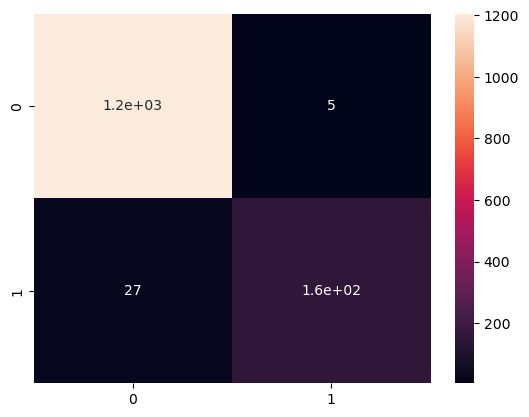

In [28]:
from sklearn.svm import SVC
model_svc = SVC()

vec_cv = CountVectorizer(max_features=150, ngram_range=(1,2))

y = df["target"]
X = df["text"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe1 = Pipeline([ 
                    ("vect", vec_cv),
                    ("model", model_svc)
])

params = ["vec_cv"]

pipe1.fit(X_train, y_train.ravel())
preds = pipe1.predict(X_test)

print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True)


#### Results

Our predictions are pretty good!

## Exercise - Try with TD-IDF

Try the previous prediction with the td-idf vectorizer. Play around with the ngrams if you have time. 

/var/folders/j5/l4n1h3z533nbg7ks96r5chn80000gn/T/ipykernel_1262/2199786220.py:18: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pipe1.fit(X_train, y_train.ravel())


              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1204
        spam       0.97      0.83      0.89       189

    accuracy                           0.97      1393
   macro avg       0.97      0.91      0.94      1393
weighted avg       0.97      0.97      0.97      1393



<Axes: >

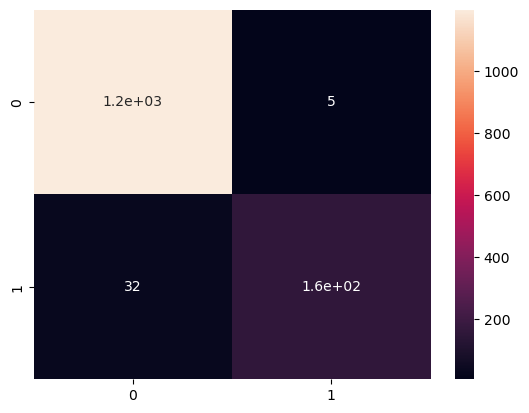

In [29]:
from sklearn.svm import SVC
model_svc = SVC()

vec_tf = TfidfVectorizer(max_features=150)

y = df["target"]
X = df["text"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe1 = Pipeline([ 
                    ("vect", vec_tf),
                    ("model", model_svc)
])

params = ["vec_cv"]

pipe1.fit(X_train, y_train.ravel())
preds = pipe1.predict(X_test)

print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True)

## More Elaborate Language Processing

In the example above we've done a "base" level of modelling - we transform the free text into something that we can process (the bag of words), and we can make predictions from it much like we would with any other one-hot encoded data. This process works fine, and it does deliver some pretty accurate results on our test data. 

To create NLP models that are more functional we can add some layers to our processing of the text to improve our understanding of the nuances of our text. Some things we can do are:
<ul>
<li> <b>Remove Stop Words</b> - common words like "it", "a", "the" are normally not all that useful in predicting the meaning, we can filter these out. 
<li> <b>Stemming</b> - coverting words down to their "stem". E.g. "reasoning" to "reason"
<li> <b>Lemmatization</b> - similar to stemming, but tries to identify the correct stem contextually. E.g. "Operating systems" probably shouldn't become "operate" and "system"
</ul>

In general, stemming increases recall while harming precision. Lemmatization has similar impacts, but tends to be less aggressive, so the effects are smaller. The specific results are highly variable depending on the exact text that is used. Something that uses specific variations of words to mean specific things (e.g. science) is more likely to get no benefit or be negatively impacted - e.g. "conditonally" used in the context of a "conditionally approved loan" is probably not well represented by changing it to "condition". 

### NLTK Library

NLTK is a library that provides a bunch of language processing stuff that we can use such as stop words and tokenizers. We'll leverage it here to make custom tokenizers to incorporate some of those features above. The things we are downloading here are pre-made sets of data, like stop words, and pretrained lists of "root words" that we can use to break words down into their root format. 

<b>Note:</b> the "for package" part there downloads the wordsets to your computer. NLTK has these prebuilt libraries of data that allow for the functions to do the stop words, stemming, and lemmatization. It might take a minute the first time you run it.

In [30]:
import nltk

for package in ['stopwords','punkt','wordnet']:
    nltk.download(package)
    
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/glennbarnes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/glennbarnes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/glennbarnes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Customized Tokenizers

The vecorization libraries in sklearn allow you do specify the function to use to do tokenization. We can use this to include other processing that we'd like as part of the process, such as removing stop words or stemming. The tokenizer functions below can, potentially, contain anything you'd like. As long as the call function returns a list of tokens, it should work. 

<b>Note:</b> if you look up examples, these functions will often be written into one lines, I broke them out so they're hopefully easier to read. They would also likely be much faster if we were to vectorize the code instead of using loops, but again, this is easy to read. 

#### Stop! In the Name of Words. Before you Break my Model.

First, we will try to make a stop word tokenizer. If something is a stop word, we shall leave it out. As noted above, we can build this into the vectorizer, so why do it? This will allow for customizing the stopwords used - some applications may have a different usage of words, so changing stopwords makes sense. It is also a super fun exercise! 

This is also the most simple example we can try :)

In [31]:
class swTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(tok)
        return filtered_tok

### Stemming and Lemmatization

Stemming and lemmatization are similar - they both aim to break words down to their "root". For example, the word "shoes" probably has the same meaning as the word "shoe" for our purposes. Each approaches this in a slightly different way, and to understand that we need to take a look at the conecpt of similarity, which we'll look at more next time. 

#### Similarity

When processing text, we can think of things being similar in two different ways - similar text or similar meaning - or lexical and semantic similarity. Things that are lexically similar use similar words, things that are semantically similar have similar meanings, even if the words are different. The stemming techniques here aren't explicit comparisons of those similarity types, but they follow the same concepts. Stemming breaks words down to their lexical root, lemmatization tries to find the semantic root.

#### Stemming

Stemming is the most simple, it just removes common prefixes and suffixes to extract the root of the word. 

In [32]:
class stemTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import SnowballStemmer
        self.stemmer = SnowballStemmer(language='english')
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(self.stemmer.stem(tok))
        return filtered_tok

#### Lemmatization

Lemmatization is slightly more sophisticated, it attempts to find the semantic root, called the lemma, of a word using a search of a dictionary (we provide one from NLTK). For example, the lemma of "better" is "good". This is a "smarter" approach that the more simple stemming function above, but it is also more complex and slower.

In [33]:
class lemmaTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import WordNetLemmatizer
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(self.lemmatizer.lemmatize(tok))
        return filtered_tok

### Predictions with More Processing and Grid Search

We can try to see which processing setup works best, the winner will depend on how the text is written. 

In [34]:
vec_tf = TfidfVectorizer()

y = df["target"]
X = df["text"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe2 = Pipeline([ 
                    #("vect", vec_cv),
                    ("vect", vec_tf),
                    ("model", model_svc)
])

params = {"vect__max_features":[100,500,1000,1500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            "vect__norm":["l1","l2"]
            }

grid = GridSearchCV(estimator  = pipe2, 
                               param_grid = params, 
                               scoring    = "balanced_accuracy",
                               cv         = 5,
                               n_jobs     =-1)

grid.fit(X_train, y_train.ravel())
best = grid.best_estimator_
preds = best.predict(X_test)
print(best)
print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True)

/var/folders/j5/l4n1h3z533nbg7ks96r5chn80000gn/T/ipykernel_1262/1326634129.py:25: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid.fit(X_train, y_train.ravel())
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be u

ValueError: 
All the 120 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 2091, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 1372, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 1259, in _count_vocab
    for feature in analyze(doc):
                   ^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 110, in _analyze
    doc = tokenizer(doc)
          ^^^^^^^^^^^^^^
  File "/var/folders/j5/l4n1h3z533nbg7ks96r5chn80000gn/T/ipykernel_1262/2508330332.py", line 5, in __call__
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/__init__.py", line 142, in word_tokenize
    sentences = [text] if preserve_line else sent_tokenize(text, language)
                                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/__init__.py", line 119, in sent_tokenize
    tokenizer = _get_punkt_tokenizer(language)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/__init__.py", line 105, in _get_punkt_tokenizer
    return PunktTokenizer(language)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/punkt.py", line 1744, in __init__
    self.load_lang(lang)
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/punkt.py", line 1749, in load_lang
    lang_dir = find(f"tokenizers/punkt_tab/{lang}/")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/data.py", line 579, in find
    raise LookupError(resource_not_found)
LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/glennbarnes/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 2091, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 1372, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 1259, in _count_vocab
    for feature in analyze(doc):
                   ^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 110, in _analyze
    doc = tokenizer(doc)
          ^^^^^^^^^^^^^^
  File "/var/folders/j5/l4n1h3z533nbg7ks96r5chn80000gn/T/ipykernel_1262/915686364.py", line 7, in __call__
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/__init__.py", line 142, in word_tokenize
    sentences = [text] if preserve_line else sent_tokenize(text, language)
                                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/__init__.py", line 119, in sent_tokenize
    tokenizer = _get_punkt_tokenizer(language)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/__init__.py", line 105, in _get_punkt_tokenizer
    return PunktTokenizer(language)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/punkt.py", line 1744, in __init__
    self.load_lang(lang)
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/punkt.py", line 1749, in load_lang
    lang_dir = find(f"tokenizers/punkt_tab/{lang}/")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/data.py", line 579, in find
    raise LookupError(resource_not_found)
LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/glennbarnes/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 2091, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 1372, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 1259, in _count_vocab
    for feature in analyze(doc):
                   ^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 110, in _analyze
    doc = tokenizer(doc)
          ^^^^^^^^^^^^^^
  File "/var/folders/j5/l4n1h3z533nbg7ks96r5chn80000gn/T/ipykernel_1262/1444532330.py", line 7, in __call__
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/__init__.py", line 142, in word_tokenize
    sentences = [text] if preserve_line else sent_tokenize(text, language)
                                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/__init__.py", line 119, in sent_tokenize
    tokenizer = _get_punkt_tokenizer(language)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/__init__.py", line 105, in _get_punkt_tokenizer
    return PunktTokenizer(language)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/punkt.py", line 1744, in __init__
    self.load_lang(lang)
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/tokenize/punkt.py", line 1749, in load_lang
    lang_dir = find(f"tokenizers/punkt_tab/{lang}/")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/nltk/data.py", line 579, in find
    raise LookupError(resource_not_found)
LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/glennbarnes/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************



##### Results

We are accurate! 

## Exercise

Categorize the following newsgroups. The data are posts from different newgroup boards. Try to categorize the data in either the atheism or religion groups. 

In [36]:
from sklearn.datasets import fetch_20newsgroups
remove = ("headers", "footers", "quotes")
categories = ["alt.atheism", "talk.religion.misc"]

data_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42, remove=remove)

data_test = fetch_20newsgroups(
    subset="test", categories=categories, shuffle=True, random_state=42, remove=remove)

X_train3 = data_train.data
y_train3 = data_train.target
X_test3 = data_test.data
y_test3 = data_test.target